Question10 - Sapphire Area Estimation

In [1]:
from pathlib import Path
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import os

In [2]:
input_image_path = "../data/a1images/sapphire.jpg" 
output_dir = "../data/output_images" 
os.makedirs(output_dir, exist_ok=True)
output_mask = f"{output_dir}/q10_mask.png"
output_filled_mask = f"{output_dir}/q10_filled_mask.png"
output_segmented = f"{output_dir}/q10_segmented.png"
output_overlay = f"{output_dir}/q10_overlay.png"
output_comparison = f"{output_dir}/q10_original_vs_segmented.png"

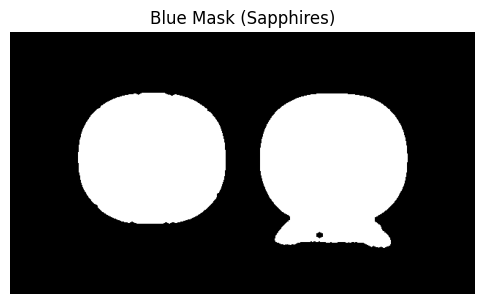

True

In [3]:
# Load the image and segment sapphires (HSV color-space)
bgr = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
if bgr is None:
    raise FileNotFoundError(input_image_path)

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
h, w = rgb.shape[:2]

# Convert to HSV (to separate the blue sapphires from the gray background)
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

# Define range for blue color (adjust as needed)
lower = np.array([100, 60, 40], dtype=np.uint8)  # Lower bound for blue hue
upper = np.array([140, 255, 255], dtype=np.uint8)  # Upper bound for blue hue
mask = cv2.inRange(hsv, lower, upper)

# Clean up small noise (small specks and fill small gaps in the mask)
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se, iterations=1)  # Remove noise
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se, iterations=2)  # Fill small gaps

# Visualize the mask to check the result
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray")
plt.title("Blue Mask (Sapphires)")
plt.axis("off")
plt.show()

# Save the mask to the output directory
cv2.imwrite(output_mask, mask)


In [4]:
# Fill holes to make each sapphire a solid blob
def fill_holes(bin255):
    inv = cv2.bitwise_not(bin255)
    h, w = inv.shape
    ffmask = np.zeros((h + 2, w + 2), np.uint8)
    flood = inv.copy()
    cv2.floodFill(flood, ffmask, (0, 0), 255)
    holes = cv2.bitwise_not(flood)
    return cv2.bitwise_or(bin255, holes)

filled_mask = fill_holes(mask)
cv2.imwrite(output_filled_mask, filled_mask)

True

In [5]:
# Apply connectedComponentsWithStats to obtain areas in pixels
num, lab, stats, _ = cv2.connectedComponentsWithStats(filled_mask, connectivity=8)
areas = [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num)]  # Get areas for each component
areas_sorted = sorted(areas, key=lambda t: t[1], reverse=True)[:2]  # Keep the two largest components
keep = {i for i, _ in areas_sorted}
final_mask = np.where(np.isin(lab, list(keep)), 255, 0).astype(np.uint8)

In [6]:
# Convert pixel areas → mm² using the camera's pinhole model
f_mm = 8.0  # focal length (in mm)
Z_mm = 480.0  # camera-to-table distance (in mm)

# Assume a standard pixel pitch (in mm). Adjust if you know the camera sensor details.
pixel_pitch_mm = 0.0048  # Default: 4.8 microns (0.0048 mm) for a typical camera

# Convert pixel area to mm² using the camera's pinhole model
mm_per_px = (Z_mm / f_mm) * pixel_pitch_mm
mm2_per_px = mm_per_px ** 2
areas_mm2 = [round(a * mm2_per_px, 3) for a in [area[1] for area in areas_sorted]]

print(f"Scale: {mm_per_px:.6f} mm/px → {mm2_per_px:.6f} mm²/px (pixel_pitch={pixel_pitch_mm} mm)")
print("Areas (pixels):", [area[1] for area in areas_sorted])
print("Areas (mm²):   ", areas_mm2)


Scale: 0.288000 mm/px → 0.082944 mm²/px (pixel_pitch=0.0048 mm)
Areas (pixels): [np.int32(34457), np.int32(30197)]
Areas (mm²):    [np.float64(2858.001), np.float64(2504.66)]


In [7]:
# Segment the rice grains and visualize the results
# Create overlay (show sapphires with filled mask)
overlay = rgb.copy()
overlay[final_mask == 0] = (overlay[final_mask == 0] * 0.25).astype(np.uint8)  # Darken background


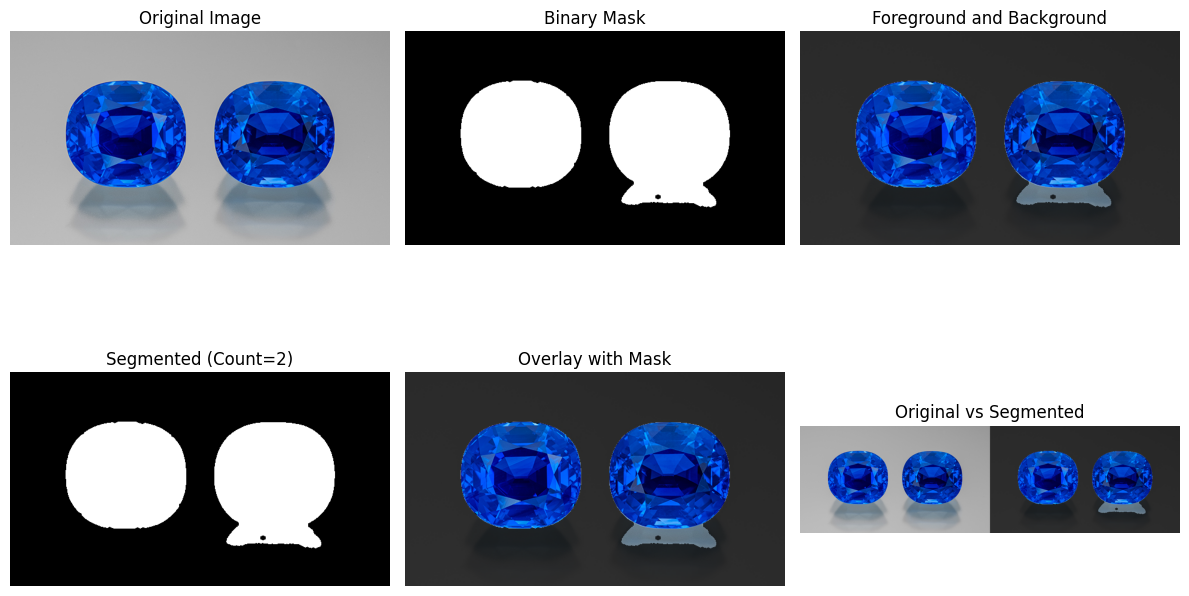

Done. Results saved to ../data/output_images.


In [8]:
# Display Results
plt.figure(figsize=(12,8))
plt.subplot(2,3,1); plt.title("Original Image");          plt.imshow(rgb); plt.axis("off")
plt.subplot(2,3,2); plt.title("Binary Mask");             plt.imshow(filled_mask, cmap="gray"); plt.axis("off")
plt.subplot(2,3,3); plt.title("Foreground and Background"); plt.imshow(overlay); plt.axis("off")
plt.subplot(2,3,4); plt.title(f"Segmented (Count={len(areas_sorted)})"); plt.imshow(final_mask, cmap="gray"); plt.axis("off")
plt.subplot(2,3,5); plt.title("Overlay with Mask");       plt.imshow(overlay); plt.axis("off")
plt.subplot(2,3,6); plt.title("Original vs Segmented");   plt.imshow(np.hstack([rgb, overlay])); plt.axis("off")
plt.tight_layout()
plt.show()

# Save all output images
cv2.imwrite(output_segmented, final_mask)
cv2.imwrite(output_overlay, overlay)
cv2.imwrite(output_comparison, cv2.cvtColor(np.hstack([rgb, overlay]), cv2.COLOR_RGB2BGR))

print(f"Done. Results saved to {output_dir}.")